In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

plt.rcParams["figure.figsize"] = (8,4)

print("Imports OK.")

Imports OK.


In [10]:
DATA_PATH = "C:\\Users\\87738\\Desktop\\ERP\\math_anxiety_processed_for_trends.csv"  
df = pd.read_csv(DATA_PATH, low_memory=False)

# Parse timestamp
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
df = df.dropna(subset=["created_at"]).copy()

# Normalize sentiment labels -> negative / neutral / positive
def norm_sent(s):
    s = str(s).strip().lower()
    if s.startswith("neg"):
        return "negative"
    if s.startswith("pos"):
        return "positive"
    return "neutral"

df["sent_label"] = df["sentiment"].map(norm_sent)
df["is_negative"] = (df["sent_label"]=="negative").astype(int)

# Month key (month start)
df["month"] = df["created_at"].values.astype("datetime64[M]")

print("Data loaded.")
print("Rows:", len(df))
print("Columns:", list(df.columns))
print(df[["created_at","month","sent_label","topic_id"]].head())

Data loaded.
Rows: 2069
Columns: ['id', 'created_at', 'month', 'text', 'sentiment', 'sent_label', 'is_negative', 'topic_id', 'topic_weight']
           created_at      month sent_label  topic_id
0 2024-04-25 16:22:00 2024-04-01   negative         7
1 2023-02-23 23:26:00 2023-02-01   negative         2
2 2024-02-16 05:31:00 2024-02-01   positive         7
3 2021-05-01 11:19:00 2021-05-01   negative         7
4 2021-09-07 01:51:00 2021-09-01   positive         2


In [11]:
monthly = (
    df.groupby("month")
      .agg(total_tweets=("sent_label","size"),
           neg_count=("is_negative","sum"))
      .reset_index()
)
monthly["neg_rate"] = monthly["neg_count"] / monthly["total_tweets"]

print("Monthly aggregates:")
print(monthly.head(10))

Monthly aggregates:
       month  total_tweets  neg_count  neg_rate
0 2021-01-01            37         20  0.540541
1 2021-02-01            38         24  0.631579
2 2021-03-01            39         20  0.512821
3 2021-04-01            39         17  0.435897
4 2021-05-01            41         21  0.512195
5 2021-06-01            35         15  0.428571
6 2021-07-01            52         28  0.538462
7 2021-08-01            47         25  0.531915
8 2021-09-01            46         26  0.565217
9 2021-10-01            40         24  0.600000


In [12]:
mt = (df.groupby(["month","topic_id"])
        .size()
        .rename("n")
        .reset_index())

# Pivot to month x topic
topic_wide = mt.pivot(index="month", columns="topic_id", values="n").fillna(0).sort_index()
# Row-normalize to shares
topic_share = topic_wide.div(topic_wide.sum(axis=1), axis=0).fillna(0)

print("Topic share (first rows):")
print(topic_share.head())

Topic share (first rows):
topic_id           0         1         2         3         4         5  \
month                                                                    
2021-01-01  0.081081  0.081081  0.108108  0.189189  0.135135  0.054054   
2021-02-01  0.026316  0.078947  0.263158  0.236842  0.078947  0.052632   
2021-03-01  0.076923  0.051282  0.153846  0.179487  0.102564  0.153846   
2021-04-01  0.051282  0.102564  0.051282  0.230769  0.102564  0.025641   
2021-05-01  0.073171  0.146341  0.195122  0.097561  0.097561  0.048780   

topic_id           6         7         8  
month                                     
2021-01-01  0.054054  0.135135  0.162162  
2021-02-01  0.000000  0.131579  0.131579  
2021-03-01  0.051282  0.102564  0.128205  
2021-04-01  0.051282  0.179487  0.205128  
2021-05-01  0.073171  0.195122  0.073171  


In [13]:
monthly_sm = monthly.set_index("month").rolling(window=3, min_periods=1).mean().reset_index()
topic_share_sm = topic_share.rolling(window=3, min_periods=1).mean()

print("Applied 3-month rolling mean (optional).")

Applied 3-month rolling mean (optional).


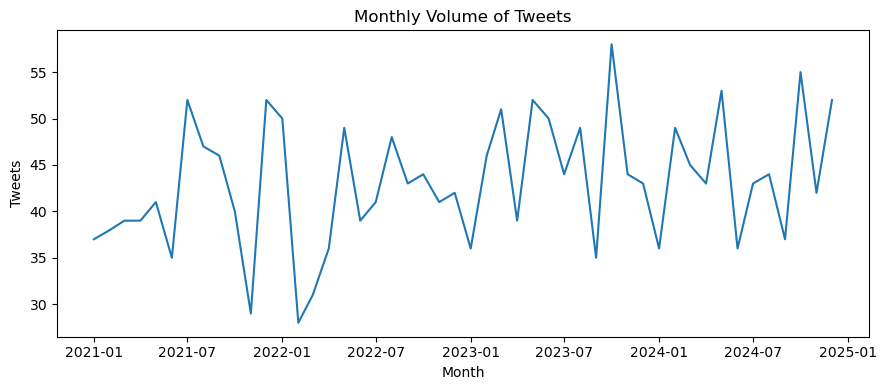

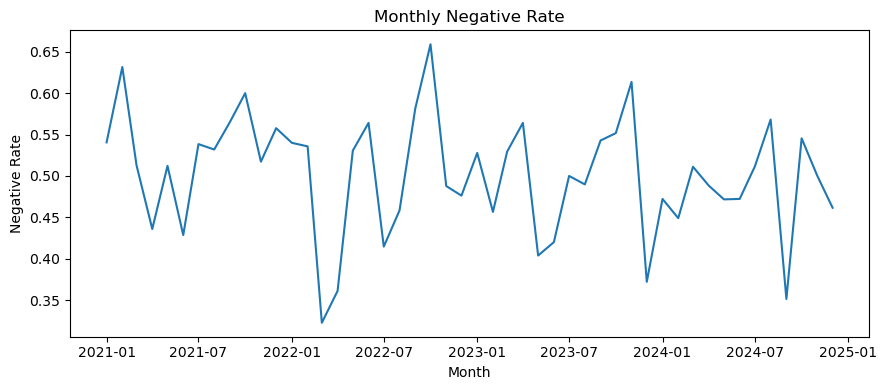

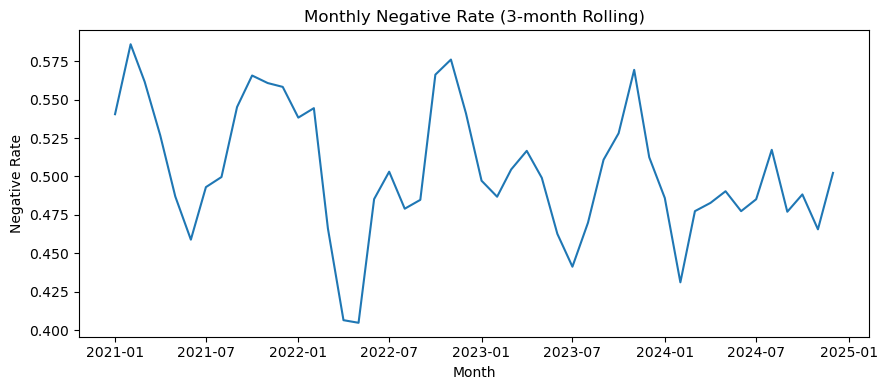

In [14]:
# a) Volume
plt.figure(figsize=(9,4))
plt.plot(monthly["month"], monthly["total_tweets"])
plt.title("Monthly Volume of Tweets")
plt.xlabel("Month")
plt.ylabel("Tweets")
plt.tight_layout()
plt.show()

# b) Negative rate
plt.figure(figsize=(9,4))
plt.plot(monthly["month"], monthly["neg_rate"])
plt.title("Monthly Negative Rate")
plt.xlabel("Month")
plt.ylabel("Negative Rate")
plt.tight_layout()
plt.show()

# c) Smoothed negative rate (optional)
plt.figure(figsize=(9,4))
plt.plot(monthly_sm["month"], monthly_sm["neg_rate"])
plt.title("Monthly Negative Rate (3-month Rolling)")
plt.xlabel("Month")
plt.ylabel("Negative Rate")
plt.tight_layout()
plt.show()


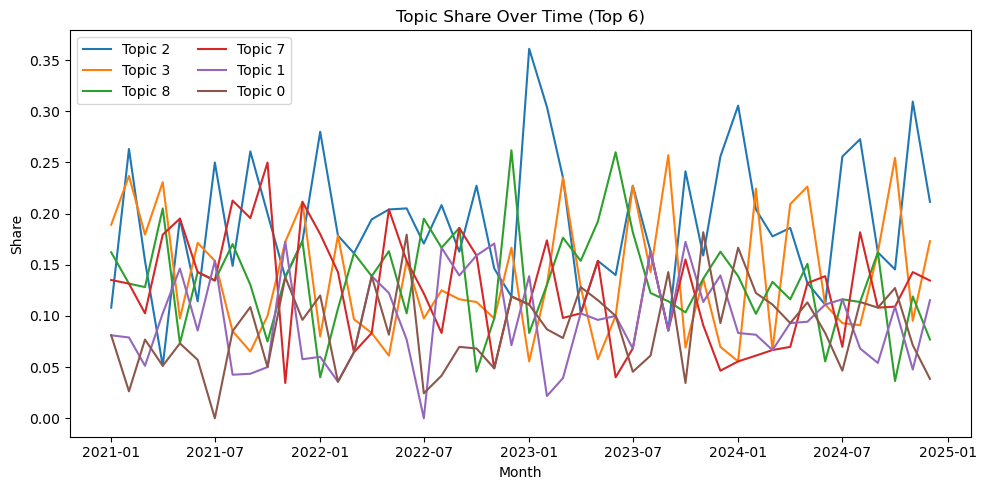

In [15]:
top_topics = topic_share.mean().sort_values(ascending=False).head(6).index.tolist()

plt.figure(figsize=(10,5))
for t in top_topics:
    plt.plot(topic_share.index, topic_share[t], label=f"Topic {t}")
plt.title("Topic Share Over Time (Top 6)")
plt.xlabel("Month")
plt.ylabel("Share")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

In [16]:
def exam_indicator(dts):
    months = set([5,6,10,11])
    return [1 if pd.Timestamp(m).month in months else 0 for m in dts]

monthly_evt = monthly.copy()
monthly_evt["exam_season"] = exam_indicator(monthly_evt["month"])

print("Monthly with exam indicator:")
print(monthly_evt.head(12)[["month","total_tweets","neg_rate","exam_season"]])

Monthly with exam indicator:
        month  total_tweets  neg_rate  exam_season
0  2021-01-01            37  0.540541            0
1  2021-02-01            38  0.631579            0
2  2021-03-01            39  0.512821            0
3  2021-04-01            39  0.435897            0
4  2021-05-01            41  0.512195            1
5  2021-06-01            35  0.428571            1
6  2021-07-01            52  0.538462            0
7  2021-08-01            47  0.531915            0
8  2021-09-01            46  0.565217            0
9  2021-10-01            40  0.600000            1
10 2021-11-01            29  0.517241            1
11 2021-12-01            52  0.557692            0


In [17]:
def spearman_corr(x, y):
    rho, p = spearmanr(x, y, nan_policy="omit")
    return rho, p

rho_vol, p_vol = spearman_corr(monthly_evt["total_tweets"], monthly_evt["exam_season"])
rho_rate, p_rate = spearman_corr(monthly_evt["neg_rate"], monthly_evt["exam_season"])

print(f"Spearman (volume vs exam): rho={rho_vol:.3f}, p={p_vol:.4f}")
print(f"Spearman (neg_rate vs exam): rho={rho_rate:.3f}, p={p_rate:.4f}")

def lagged_corr(series, indicator, k=1):
    s = series.reset_index(drop=True)
    ind = pd.Series(indicator).shift(-k)  
    rho, p = spearmanr(s, ind, nan_policy="omit")
    return rho, p

for k in [1,2,3]:
    rho_lag, p_lag = lagged_corr(monthly_evt["neg_rate"], monthly_evt["exam_season"], k=k)
    print(f"Lagged Spearman (neg_rate vs exam, exam leads {k}m): rho={rho_lag:.3f}, p={p_lag:.4f}")

Spearman (volume vs exam): rho=0.099, p=0.5029
Spearman (neg_rate vs exam): rho=0.107, p=0.4697
Lagged Spearman (neg_rate vs exam, exam leads 1m): rho=0.137, p=0.3571
Lagged Spearman (neg_rate vs exam, exam leads 2m): rho=-0.053, p=0.7250
Lagged Spearman (neg_rate vs exam, exam leads 3m): rho=-0.075, p=0.6241
